In [1]:
# increase default window size for notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

C:\Users\s.kaiser\AppData\Local\Temp\ipykernel_37080\696421802.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# one time install
# !pip install theano

In [3]:
import sys, os
cwd = sys.path[0]
sys.path.append(os.path.join(cwd, 'my_modules'))                # sys.path[0] is dir of the ipynb file
import custom_plot
import data_clean
import data_preprocess
import constants

imported custom_plot.py
data_clean imported
data_preprocess imported


In [5]:
# import os;
# import theano
# os.environ['KERAS_BACKEND'] = 'theano'
# !python --version
# theano.test()

Python 3.9.7


In [6]:
import os
# os.environ["KERAS_BACKEND"] = "theano"
import keras; import keras.backend
print(keras.backend.backend())   # check keras backend
# if keras.backend.backend() != 'theano':
#     raise BaseException("This script uses other backend")
# else:
#     keras.backend.set_image_dim_ordering('th')
#     print("Backend ok")


tensorflow


In [55]:
import numpy as np
from standard_plots import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline


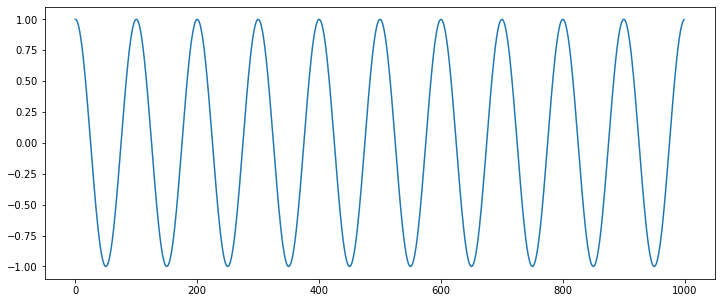

In [45]:
dataset = np.cos(np.arange(1000)*(20*np.pi/1000))[:,None]
# print(dataset)
plt_plot(y = dataset)

In [46]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [47]:
look_back = 20
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_val_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_val_size
train_val, test = dataset[0:train_val_size,:], dataset[train_val_size:len(dataset),:]

# validation data, first 80% of train_val is train, rest is validation data
train_size = int(len(train_val) * 0.8)
val_size = len(train_val) - train_size
train, val = dataset[0:train_size,:], train_val[train_size:len(train_val),:]

trainX, trainY = create_dataset(train, look_back)
val_X, val_y = create_dataset(val, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
val_X = np.reshape(val_X, (val_X.shape[0], val_X.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

print(len(dataset), train_val_size, test_size, train_size, val_size)

1000 800 200 640 160


In [48]:
# print(trainX)
# print(trainY)
print(train.shape)
print(trainX.shape)
print(val_X.shape)
print(testX.shape)

(640, 1)
(620, 20, 1)
(140, 20, 1)
(180, 20, 1)


In [82]:
%%time
dir_path = os.path.join(cwd, 'test_cosine')
model_path = os.path.join(dir_path, 'model.h5')
all_history = pd.DataFrame()

# theano.config.compute_test_value = "ignore"
# create and fit the LSTM network
batch_size = 1
model = Sequential()
# model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
# model.add(Dropout(0.3))
# model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
# model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))
model.summary()

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,verbose=0,mode='min'),  # minimize validation loss
    tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss', mode='min', save_best_only=True)
]
# loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanSquaredError()]
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanSquaredError()])
for i in range(100):
    history = model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, validation_data=(val_X, val_y), callbacks=my_callbacks, shuffle=False)
    this_history = pd.DataFrame(history.history)
    all_history = pd.concat([all_history, this_history])
    model.reset_states()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (1, 32)                   4352      
                                                                 
 dropout_11 (Dropout)        (1, 32)                   0         
                                                                 
 dense_11 (Dense)            (1, 1)                    33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
620/620 - 5s - loss: 0.1419 - mean_squared_error: 0.1419 - val_loss: 0.0440 - val_mean_squared_error: 0.0440 - 5s/epoch - 8ms/step
620/620 - 3s - loss: 0.0602 - mean_squared_error: 0.0602 - val_loss: 0.0379 - val_mean_squared_error: 0.0379 - 3s/epoch - 5ms/step
620/620 - 3s - loss: 0.0478 - mean_squared_error: 0.0

620/620 - 3s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 3.2529e-04 - val_mean_squared_error: 3.2529e-04 - 3s/epoch - 4ms/step
620/620 - 2s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 6.7862e-04 - val_mean_squared_error: 6.7862e-04 - 2s/epoch - 4ms/step
620/620 - 3s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 3.8587e-04 - val_mean_squared_error: 3.8587e-04 - 3s/epoch - 4ms/step
620/620 - 3s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 4.6933e-05 - val_mean_squared_error: 4.6933e-05 - 3s/epoch - 5ms/step
620/620 - 3s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 2.5894e-04 - val_mean_squared_error: 2.5894e-04 - 3s/epoch - 4ms/step
620/620 - 3s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 1.4118e-05 - val_mean_squared_error: 1.4118e-05 - 3s/epoch - 5ms/step
620/620 - 3s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 3.4389e-05 - val_mean_squared_error: 3.4389e-05 - 3s/epoch - 5ms/step
620/620 - 3s - loss: 0.0029

        loss  mean_squared_error  val_loss  val_mean_squared_error
0   0.141905            0.141905  0.044040                0.044040
0   0.060175            0.060175  0.037882                0.037882
0   0.047756            0.047756  0.024913                0.024913
0   0.032568            0.032568  0.020307                0.020307
0   0.026600            0.026600  0.014321                0.014321
..       ...                 ...       ...                     ...
0   0.002221            0.002221  0.000198                0.000198
0   0.002158            0.002158  0.000144                0.000144
0   0.002225            0.002225  0.000187                0.000187
0   0.001866            0.001866  0.000046                0.000046
0   0.001920            0.001920  0.000024                0.000024

[100 rows x 4 columns]


<IPython.core.display.Javascript object>


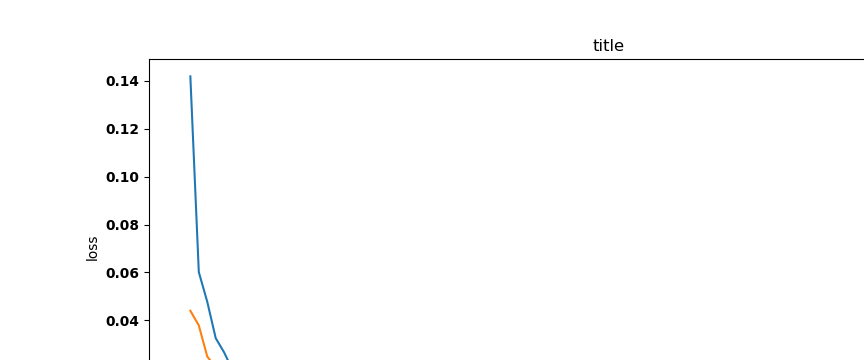

{'loss': [0.1419050097465515, 0.06017450615763664, 0.047755807638168335, 0.03256809338927269, 0.026599576696753502, 0.019184192642569542, 0.014005191624164581, 0.010595599189400673, 0.009981842711567879, 0.007695088163018227, 0.007028879597783089, 0.006986913271248341, 0.006352491211146116, 0.006222440395504236, 0.005661732982844114, 0.005554875824600458, 0.0055571431294083595, 0.004571450408548117, 0.00423698965460062, 0.0048650405369699, 0.005184317473322153, 0.0049096085131168365, 0.0043678381480276585, 0.003973267041146755, 0.004648569971323013, 0.003827099921181798, 0.004180824849754572, 0.004040908999741077, 0.004319364205002785, 0.0038844351656734943, 0.0036543754395097494, 0.003432275028899312, 0.004190240986645222, 0.00399860180914402, 0.003167495597153902, 0.0037877028807997704, 0.003687897464260459, 0.0031809373758733273, 0.0033946125768125057, 0.0033986580092459917, 0.003382509807124734, 0.0036124237813055515, 0.0034725270234048367, 0.003297216724604368, 0.00298976479098200

In [83]:
%matplotlib notebook
print(all_history)

# Plot history (train, val loss vs epochs)

# v = all_history.values.tolist()
# c = all_history.columns.values.tolist()
# dict_history = [dict(zip(c, x)) for x in v]

import matplotlib
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 10}

matplotlib.rc('font', **font)
fig = plt.figure(figsize =(12 ,5))
dict_history = all_history.to_dict('list')
print(dict_history)
# print('train loss: ', dict_history['loss'])
# print('val loss: ', dict_history['val_loss'])
plt.plot(dict_history['loss'])
plt.plot(dict_history['val_loss'])
plt.title('title')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [84]:
trainScore = model.evaluate(trainX, trainY, batch_size=batch_size, verbose=0)
print('Train Score: ', trainScore)
testScore = model.evaluate(testX[:252], testY[:252], batch_size=batch_size, verbose=0)
print('Test Score: ', testScore)


Train Score:  [3.300166645203717e-05, 3.300166645203717e-05]
Test Score:  [4.148622610955499e-05, 4.148622610955499e-05]


In [85]:
look_ahead = 250
trainPredict = [np.vstack([trainX[-1][1:], trainY[-1]])]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([trainPredict[-1]]), batch_size=batch_size)
    predictions[i] = prediction
    trainPredict.append(np.vstack([trainPredict[-1][1:],prediction]))


<IPython.core.display.Javascript object>


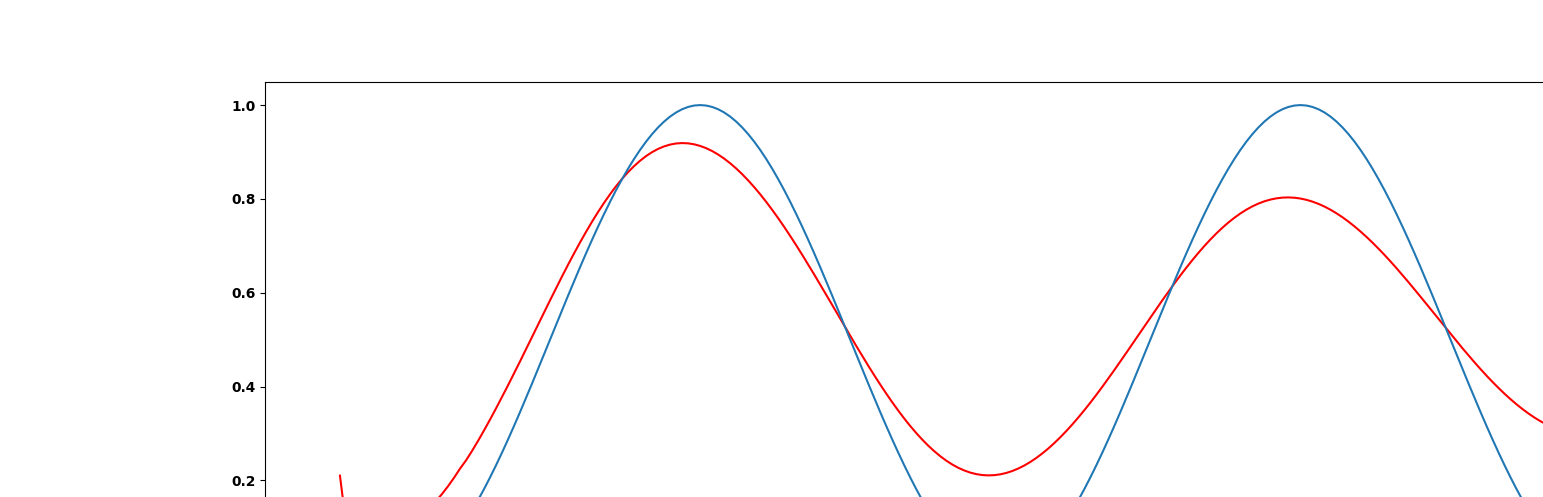

In [86]:
plt.figure(figsize=(12,5))
# plt.plot(np.arange(len(trainX)),np.squeeze(trainX))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(trainPredict)[:,None][1:]))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(testY)[:,None][:200]),'r')
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),dataset[train_size:(train_size+look_ahead)],label="test function")
plt.legend()
plt.show()